<a href="https://colab.research.google.com/github/aniketsharma00411/ML-Zoomcamp/blob/main/Session%206/Session%206.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 6

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import  RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [2]:
! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

--2021-10-20 14:12:52--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv’

AB_NYC_2019.csv     100%[===================>]   6.75M  --.-KB/s    in 0.1s    

2021-10-20 14:12:55 (66.2 MB/s) - ‘AB_NYC_2019.csv’ saved [7077973/7077973]



In [3]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
target = np.log1p(df.price)

del df['price']

In [5]:
X_full_train, X_test, y_full_train, y_test = train_test_split(df, target, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

Now, use `DictVectorizer` to turn train and validation into matrices:

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = X_train.to_dict(orient='records')
X_train_transformed = dv.fit_transform(train_dict)

val_dict = X_val.to_dict(orient='records')
X_val_transformed = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [7]:
model1 = DecisionTreeRegressor(max_depth=1)

model1.fit(X_train_transformed, y_train)

print(export_text(model1, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* **`room_type`**
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [8]:
model2 = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

model2.fit(X_train_transformed, y_train)

mean_squared_error(model2.predict(X_val_transformed), y_val, squared=False)

0.460888788095762

What's the RMSE of this model on validation?

* 0.059
* 0.259
* **0.459**
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [9]:
scores = {}
for n_estimators in range(10, 201, 10):
    model3 = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    model3.fit(X_train_transformed, y_train)

    scores[n_estimators] = mean_squared_error(model3.predict(X_val_transformed), y_val, squared=False)

scores

{10: 0.460888788095762,
 20: 0.44744055425901735,
 30: 0.44440015830200136,
 40: 0.44281711871165336,
 50: 0.44176815762157207,
 60: 0.44125165338475053,
 70: 0.44064455072014125,
 80: 0.44074083026304695,
 90: 0.44027490203116176,
 100: 0.4397631903425602,
 110: 0.4393128261208466,
 120: 0.43912990819267467,
 130: 0.4392796575512702,
 140: 0.4391514983746916,
 150: 0.43902892484355854,
 160: 0.4388423640549406,
 170: 0.4387460509023033,
 180: 0.4388528948224223,
 190: 0.43879074353852315,
 200: 0.4387871286025359}

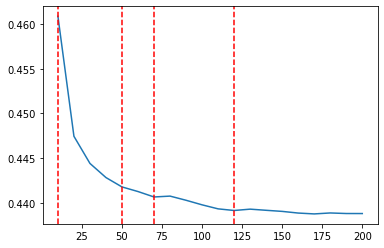

In [10]:
plt.plot(list(scores.keys()), list(scores.values()))

plt.axvline(10, color='r', linestyle='--')
plt.axvline(50, color='r', linestyle='--')
plt.axvline(70, color='r', linestyle='--')
plt.axvline(120, color='r', linestyle='--')

plt.show()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- **120**

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [11]:
scores = {}
for max_depth in [10, 15, 20, 25]:
    scores[max_depth] = {}
    for n_estimators in range(10, 201, 10):
        model4 = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=1,
            n_jobs=-1
        )
        model4.fit(X_train_transformed, y_train)

        scores[max_depth][n_estimators] = mean_squared_error(model4.predict(X_val_transformed), y_val, squared=False)

scores

{10: {10: 0.44520997451725497,
  20: 0.44188768969228903,
  30: 0.4412072430403244,
  40: 0.441302539566751,
  50: 0.44094661033788907,
  60: 0.4410194069419074,
  70: 0.4408176000010481,
  80: 0.4406786332321829,
  90: 0.44039309045805686,
  100: 0.44016087713810426,
  110: 0.4401070986887385,
  120: 0.43988415134762726,
  130: 0.4399221119826575,
  140: 0.43991391462947493,
  150: 0.4397403211692405,
  160: 0.4396909000703574,
  170: 0.43966710118276714,
  180: 0.43978907843722126,
  190: 0.43973084347364055,
  200: 0.4397273925569717},
 15: {10: 0.4502764734468855,
  20: 0.4412498927762147,
  30: 0.4397632942548365,
  40: 0.43889977393932633,
  50: 0.43808317617709414,
  60: 0.43776561899596245,
  70: 0.43737018304491615,
  80: 0.43723853057685913,
  90: 0.43682458657973466,
  100: 0.4364995813365257,
  110: 0.43623556376114225,
  120: 0.436221775229202,
  130: 0.43625311956400475,
  140: 0.43613464382761596,
  150: 0.4361678070168537,
  160: 0.43598032251716634,
  170: 0.4358902747

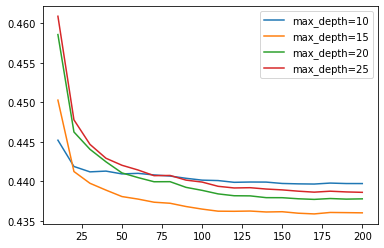

In [12]:
for max_depth, score in scores.items():
    plt.plot(list(score.keys()), list(score.values()), label=f'max_depth={max_depth}')

plt.legend()

plt.show()

What's the best `max_depth`:

* 10
* **15**
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [13]:
model5 = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
model5.fit(X_train_transformed, y_train)

list(zip(dv.get_feature_names(), model5.feature_importances_))

[('availability_365', 0.07651608462923112),
 ('calculated_host_listings_count', 0.030906352520589986),
 ('latitude', 0.15205397490899036),
 ('longitude', 0.15321933669623872),
 ('minimum_nights', 0.0536452299566982),
 ('neighbourhood_group=Bronx', 0.0002838225491492307),
 ('neighbourhood_group=Brooklyn', 0.0011661162111558155),
 ('neighbourhood_group=Manhattan', 0.03401674428986242),
 ('neighbourhood_group=Queens', 0.0011532423357895512),
 ('neighbourhood_group=Staten Island', 0.00011802695206485345),
 ('number_of_reviews', 0.0435248857335957),
 ('reviews_per_month', 0.05243793489874994),
 ('room_type=Entire home/apt', 0.3918968371926611),
 ('room_type=Private room', 0.004520617592045859),
 ('room_type=Shared room', 0.004540793533177226)]

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* **`room_type=Entire home/apt`**
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [14]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train_transformed, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val_transformed, label=y_val, feature_names=features)

In [15]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [16]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model61 = xgb.train(
    xgb_params,
    dtrain,
    evals=watchlist
)

[0]	train-rmse:3.02752	val-rmse:3.02415
[1]	train-rmse:2.14667	val-rmse:2.1439
[2]	train-rmse:1.53878	val-rmse:1.53721
[3]	train-rmse:1.12557	val-rmse:1.12524
[4]	train-rmse:0.851002	val-rmse:0.851752
[5]	train-rmse:0.674904	val-rmse:0.677523
[6]	train-rmse:0.566867	val-rmse:0.571483
[7]	train-rmse:0.504476	val-rmse:0.511388
[8]	train-rmse:0.469135	val-rmse:0.477768
[9]	train-rmse:0.450101	val-rmse:0.459656


Now change `eta` first to `0.1` and then to `0.01`

In [17]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model62 = xgb.train(
    xgb_params,
    dtrain,
    evals=watchlist
)

[0]	train-rmse:3.87217	val-rmse:3.86889
[1]	train-rmse:3.4915	val-rmse:3.4884
[2]	train-rmse:3.14949	val-rmse:3.14635
[3]	train-rmse:2.84231	val-rmse:2.83953
[4]	train-rmse:2.56649	val-rmse:2.56407
[5]	train-rmse:2.31905	val-rmse:2.31689
[6]	train-rmse:2.09713	val-rmse:2.09526
[7]	train-rmse:1.89832	val-rmse:1.89664
[8]	train-rmse:1.72031	val-rmse:1.71879
[9]	train-rmse:1.5612	val-rmse:1.55978


In [18]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model63 = xgb.train(
    xgb_params,
    dtrain,
    evals=watchlist
)

[0]	train-rmse:4.25336	val-rmse:4.2501
[1]	train-rmse:4.21141	val-rmse:4.20815
[2]	train-rmse:4.16988	val-rmse:4.16661
[3]	train-rmse:4.12877	val-rmse:4.12551
[4]	train-rmse:4.08807	val-rmse:4.08481
[5]	train-rmse:4.04779	val-rmse:4.04454
[6]	train-rmse:4.00792	val-rmse:4.00467
[7]	train-rmse:3.96845	val-rmse:3.96521
[8]	train-rmse:3.92937	val-rmse:3.92616
[9]	train-rmse:3.8907	val-rmse:3.88749


Which eta leads to the best RMSE score on the validation dataset?

* **0.3**
* 0.1
* 0.01